# Binaural synthesis

Humans can localize the distance and angular position of sound sources by extracting and interpreting acoustic cues from the acoustic pressure signals arriving at the left and right ear.
This is possible because incoming sound is altered depending on its direction of incidence due to reflections, diffraction, and resonances caused by the outer ear (pinna), head, and torso.
The ear signals are termed _binaural_ signals.
If binaural signals perfectly reproduced at the ears of a listener, for example via headphone playback, this will evoke an auditory illusion of a virtual sound source that can be placed at an arbitrary position in space.
Such a reproduction of binaural signals is termed _binaural synthesis_, and the examples below show how this can be realized with a special filters and anechoic audio content.

## HRTF dataset

A valid way to describe all linear sound transformations caused by torso, head, and pinna is using so-called “head-related transfer functions” (HRTFs).
For each direction of sound incidence from a sound source to a human receiver, two transfer functions exist (one for the left and one for the right ear), combined into a two-channel HRTF in the frequency domain.
Combining all directions into a single database is commonly called an HRTF dataset.
The time domain version of HRTFs are also known as "head-related impulse responses" (HRIRs).

In [1]:
%matplotlib inline
# import the required packages
import pyfar as pf
import sofar as sf
import numpy as np
import matplotlib.pyplot as plt

# load an example HRIR dataset
hrirs, sources = pf.signals.files.head_related_impulse_responses(position='horizontal', diffuse_field_compensation=True)

Here we are loading the included HRIR dataset from the FABIAN dummy head by [Brinkmann _et al._](https://depositonce.tu-berlin.de/items/3b423df7-a764-4ce1-9065-4e6034bba759).
pyfar includes a [method to load specific HRIRs from the dataset](https://pyfar.readthedocs.io/en/stable/modules/pyfar.signals.files.html#pyfar.signals.files.head_related_impulse_responses).

First, we will plot all possible source locations that are contained in the dataset.

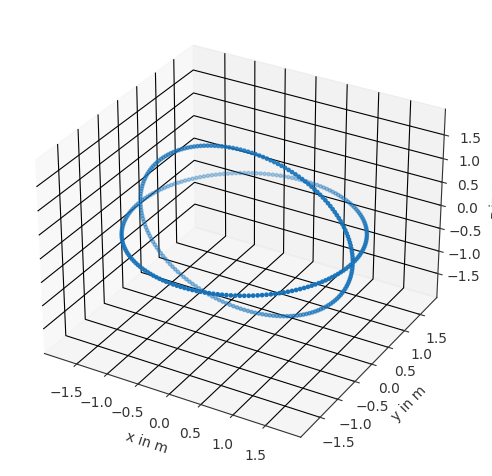

In [2]:
sources.show()

ax = plt.gca()
ax.set_box_aspect([
    np.ptp(sources.x),
    np.ptp(sources.y),
    0.1,
])
ax.view_init(90, -90, 0)
ax.view_init(90, -90, 0)
ax.set_zticklabels([])
ax.set_zlabel('')
ax.set_in_layout(False)

We can see that the included dataset only contains a limited number of source positions - namely, the horizontal plane and the median plane.
In practice, an HRIR dataset usually contains more source positions covering the whole sphere around the listener.

Using the pyfar coordinates, <!-- LINK TODO --> a specific direction can be selected from the dataset.

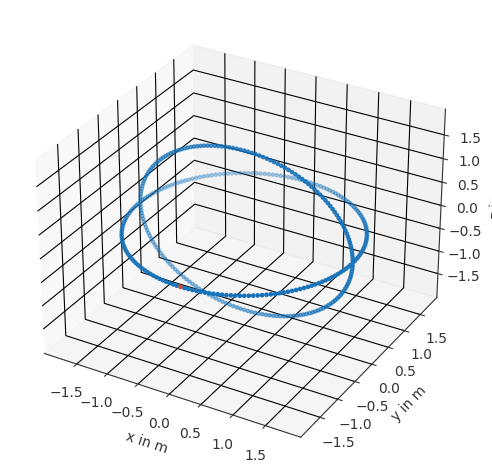

In [3]:
# define the direction of the desired sound source; here, we choose the right direction
elevation = 0
azimuth = -90

# convert to radians
elevation = elevation * np.pi / 180
azimuth = azimuth * np.pi / 180

desired_direction = pf.Coordinates.from_spherical_elevation(
    azimuth, elevation, 2
)

index, _ = sources.find_nearest(desired_direction)

sources.show(index)

ax = plt.gca()
ax.set_box_aspect([
    np.ptp(sources.x),
    np.ptp(sources.y),
    0.1,
])
ax.view_init(90, -90, 0)
ax.set_zticklabels([])
ax.set_zlabel('')
ax.set_in_layout(False)

In the plot, the selected direction is marked with a red dot.

With an HRIR selected, we can plot it in the time and frequency domain.

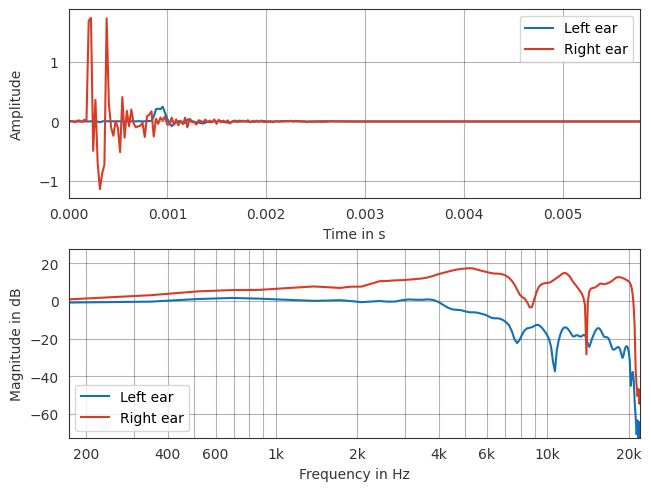

In [4]:
ax = pf.plot.time_freq(hrirs[index], label=["Left ear", "Right ear"])
ax[0].legend()
ax[1].legend()

## Creating a binaural synthesis

The binaural synthesis is done by convolving a mono, anechoic signal with an HRIR.
The following code shows how to do this with pyfar.

First,the audio signal is loaded and plotted in the time domain.
You can also listen to it!

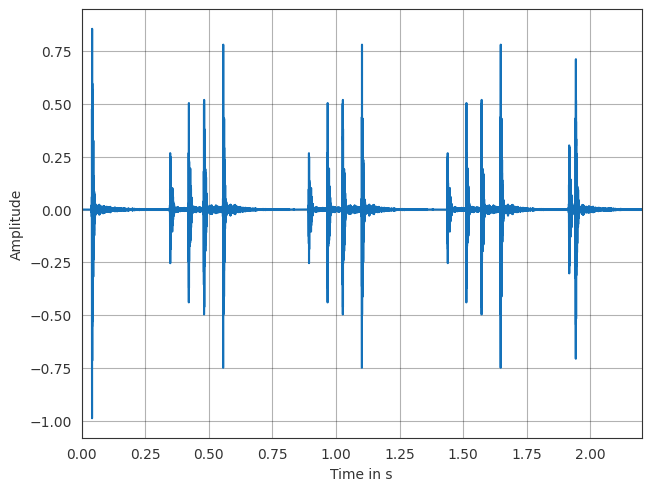

In [6]:
from IPython.display import Audio

castanets = pf.signals.files.castanets()

pf.plot.time(castanets)

Audio(castanets.time, rate=castanets.sampling_rate)

Next, we will create a binaural synthesis from this signal by convolving the audio signal with the HRIR we selected before.

<span style="color:red; font-size:1.3em;">**Please use headphones for listening to binaural signals.**</span>

In [7]:
# apply the HRIRs to the audio signal
binaural_audio = pf.dsp.convolve(castanets, hrirs[index])
binaural_audio = pf.dsp.normalize(binaural_audio)

Audio(binaural_audio.time, rate=binaural_audio.sampling_rate)

The castanets should now be heard from the right.
In addition, the castanets should be externalized, which means that they sound like they are coming from outside your head.
Feel free to compare this to the mono version to really hear the difference!

## Interactive example

Last but not least, we will create an interactive example that allows you to select a source position and listen to the binaural synthesis.
In addition, we will also use two signals to demonstrate the effect of the binaural synthesis.

In [8]:
from ipywidgets import (
    GridspecLayout,
    Button,
    Layout,
    IntSlider,
    interactive_output,
)

guitar = pf.signals.files.guitar(44100)
guitar.time = guitar.time[:,:castanets.n_samples]


def convolve_with_hrir(azimuth, audio, hrirs, gain=1.0):
    # convert to radians
    azimuth = azimuth * np.pi / 180

    # define the direction of the desired sound source
    desired_direction = pf.Coordinates.from_spherical_elevation(
        azimuth, 0, 2
    )

    # find the nearest HRIRs to the desired direction
    index, _ = sources.find_nearest(desired_direction)

    # apply the HRIRs to the audio signal
    output_audio = pf.dsp.convolve(audio, hrirs[index])
    output_audio = 10 ** (gain / 20) * pf.dsp.normalize(output_audio)

    return output_audio


def interactive_demo(castanets_azimuth, castanets_gain, guitar_azimuth, guitar_gain):
    castanets_audio = convolve_with_hrir(castanets_azimuth, castanets, hrirs, castanets_gain)
    guitar_audio = convolve_with_hrir(guitar_azimuth, guitar, hrirs, guitar_gain)

    mixed_audio = pf.classes.audio.add((castanets_audio, guitar_audio), domain="time")

    mixed_audio = pf.dsp.normalize(mixed_audio)

    display(Audio(mixed_audio.time, rate=mixed_audio.sampling_rate, normalize=False))

castanets_btn = Button(
    description="Castanets",
    button_style="success",
    layout=Layout(height="auto", width="auto"),
)
guitar_btn = Button(
    description="Guitar",
    button_style="success",
    layout=Layout(height="auto", width="auto"),
)
castanets_az_sl = IntSlider(
    value=90,
    min=-180,
    max=180,
    step=5,
    description="Azimuth [deg]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)
castanets_gain_sl = IntSlider(
    value=0,
    min=-50,
    max=0,
    step=1,
    description="Gain [dB]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)
guitar_az_sl = IntSlider(
    value=-90,
    min=-180,
    max=180,
    step=5,
    description="Azimuth [deg]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)
guitar_gain_sl = IntSlider(
    value=0,
    min=-50,
    max=0,
    step=1,
    description="Gain [dB]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)

grid = GridspecLayout(3, 2, height="200px")
grid[0, 0] = castanets_btn
grid[1, 0] = castanets_az_sl
grid[2, 0] = castanets_gain_sl
grid[0, 1] = guitar_btn
grid[1, 1] = guitar_az_sl
grid[2, 1] = guitar_gain_sl

out = interactive_output(
    interactive_demo,
    {
        "castanets_azimuth": castanets_az_sl,
        "castanets_gain": castanets_gain_sl,
        "guitar_azimuth": guitar_az_sl,
        "guitar_gain": guitar_gain_sl,
    },
)

display(grid, out)

Loading guitar data. This is only done once.


GridspecLayout(children=(Button(button_style='success', description='Castanets', layout=Layout(grid_area='widg…

Output()